Idea: Extend LTH to feature selection - Pruning + gradient descent for feature selection

Result:

With 70% of features remaining, we are able to get better accuracy and training time

The red pixels are the features that are ignored in the final feature subset

And this feature subset extends across neural networks. One important limitation of the original LTH paper is that it only works with same random weights. Literature later identified supermasks that, when applied to new random weights, do better than random, but is not nearly comparable to original performance. 

By applying the same pruning technique to feature selection, however, we find that unlike LTH for NN parameters, the feature subset is elastic, i.e., it is able to extend even to new random weights

----> nvm, it does better than randomly just destorying 50% of the weights, but barely better. So for MNIST in general, if you remove 50% of the pixels you can do decent, this is just confirming that and is not anythiing special.

In [1]:
import numpy as np
import torch

In [2]:
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
import torchvision.transforms.functional as F

dtype = torch.float32

In [3]:
batch_size = 64

mnist_train = datasets.MNIST('.', download = True, train = True, transform = T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(50000)))

mnist_val = datasets.MNIST('.', download = True, train = True, transform = T.ToTensor())
loader_val = DataLoader(mnist_val, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(50000, 60000)))

torch.Size([64, 1, 28, 28])


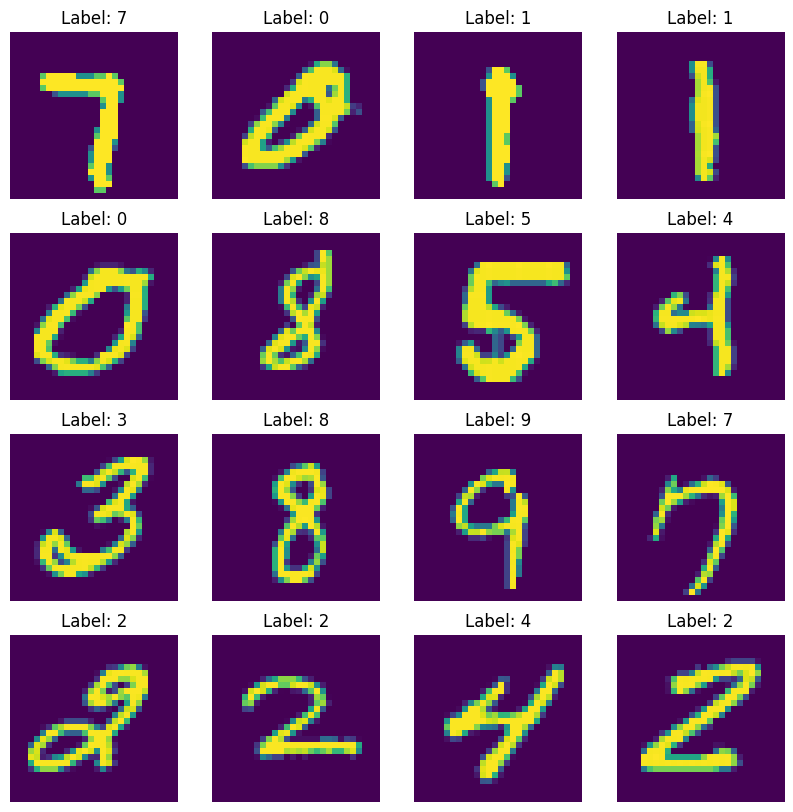

In [4]:
images, labels = next(iter(loader_train))

# Print the shape of the images and labels
print(images.shape)

# Plot the images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].permute(1, 2, 0))
    ax.axis('off')
    ax.set_title(f"Label: {labels[i]}")

plt.show()


In [5]:
def two_layer_fc(x, params):
    x = x.view(-1, 28 * 28)
    w1, w2, mult = params

    x *= mult.view(1, -1)
    x = torch.relu(x @ w1)
    x = x @ w2
    
    return x

# Example usage:
dtype = torch.float
batch_size = 64  # Assuming a batch size is defined somewhere.

x = torch.zeros((batch_size, 28 * 28), dtype=dtype)
hidden_layer_size = 42

w1 = torch.zeros((28 * 28, hidden_layer_size), dtype=dtype, requires_grad=True)
w2 = torch.zeros((hidden_layer_size, 10), dtype=dtype, requires_grad=True)
mult = torch.zeros((28 * 28), dtype=dtype, requires_grad=True)

scores = two_layer_fc(x, [w1, w2, mult])
# Mult is a diagonal matrix

In [6]:
def random_weight(shape):
    if len(shape) == 2:
        fan_in = shape[0]
    else:
        fan_in = np.prod(shape[1:])
    
    w = torch.randn(shape, dtype=dtype) * np.sqrt(2. / fan_in)
    w.requires_grad = True
    
    return w

def zero_weight(shape):
    return torch.zeros(shape, dtype=dtype, requires_grad=True)

# create a weight of shape [3 x 5]
# you should see the type `torch.cuda.FloatTensor` if you use GPU.
# Otherwise it should be `torch.FloatTensor`
random_weight((3, 5))

tensor([[ 0.6456, -0.0370, -0.6387,  0.7005, -0.5316],
        [ 0.2039,  0.5824, -0.6153, -1.1580,  0.9776],
        [ 0.2892, -0.4458,  0.6839,  1.3925,  0.0469]], requires_grad=True)

In [17]:
def check_accuracy(loader, model_fn, params, verbose=False):
    split = 'val' if loader.dataset.train else 'test'
    
    if verbose:
        print('Checking accuracy on the %s set' % split)
    
    num_correct, num_samples = 0, 0
    with torch.no_grad():
        for x, y in loader:
            scores = model_fn(x, params)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        
        if verbose:
            print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))
        
        return acc

In [24]:
def train(model_fn, params, learning_rate, print_every=100, verbose = True):
    w1, w2, mult, m1, m2, m3 = params 
    
    for t, (x, y) in enumerate(loader_train):
        
        with torch.no_grad():
            w1 *= m1
            w2 *= m2
            mult *= m3
            
        scores = model_fn(x, [w1, w2, mult])
        loss = torch.nn.functional.cross_entropy(scores, y)
        loss.backward()
        
        with torch.no_grad():
            
            w1 -= learning_rate * w1.grad
            w2 -= learning_rate * w2.grad
            mult -= learning_rate * mult.grad

            w1.grad.zero_()
            w2.grad.zero_()
            mult.grad.zero_()

        if t % print_every == 0 and verbose:            
            print('Iteration %d, loss = %.4f' % (t, loss.item()))
            
        with torch.no_grad():
            w1 *= m1
            w2 *= m2
            mult *= m3
        
    res = check_accuracy(loader_val, model_fn, [w1, w2, mult], True)
    
    return res

Iteration 0, loss = 2.5311
Iteration 200, loss = 0.8294
Iteration 400, loss = 0.5731
Iteration 600, loss = 0.4729
Checking accuracy on the val set
Got 8908 / 10000 correct (89.08%)
Iteration 0, loss = 0.4368
Iteration 200, loss = 0.3763
Iteration 400, loss = 0.4154
Iteration 600, loss = 0.4250
Checking accuracy on the val set
Got 9117 / 10000 correct (91.17%)
--------------------------------------------------------------------------------------------------------------------------------
1 iteration of pruning done Remaining Features: 95.02551020408163 %
--------------------------------------------------------------------------------------------------------------------------------


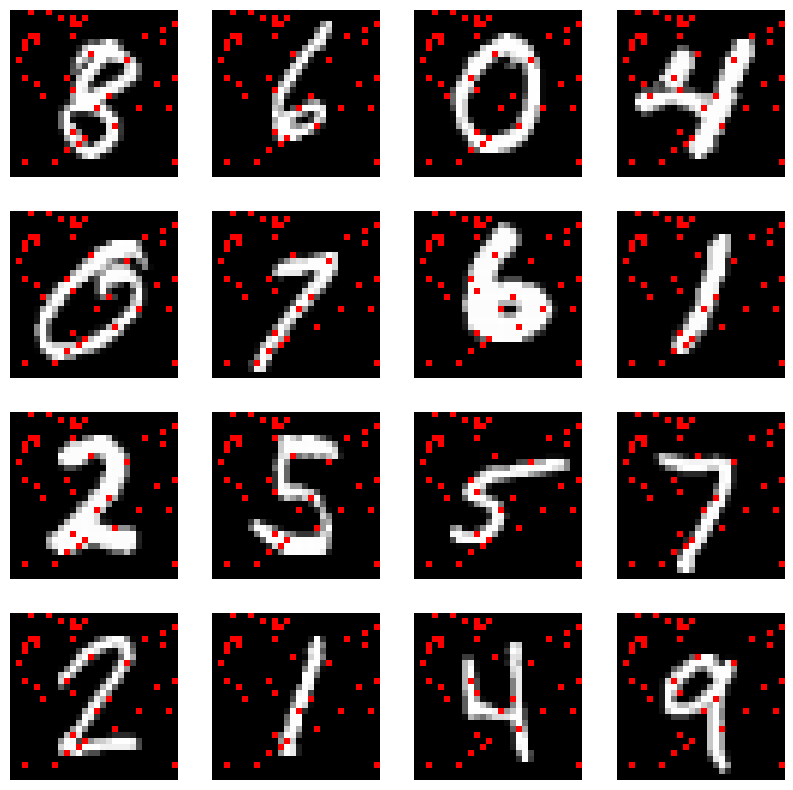

Iteration 0, loss = 2.4678
Iteration 200, loss = 0.7458
Iteration 400, loss = 0.6465
Iteration 600, loss = 0.5126
Checking accuracy on the val set
Got 8937 / 10000 correct (89.37%)
Iteration 0, loss = 0.5277
Iteration 200, loss = 0.2675
Iteration 400, loss = 0.2109
Iteration 600, loss = 0.3349
Checking accuracy on the val set
Got 9133 / 10000 correct (91.33%)
--------------------------------------------------------------------------------------------------------------------------------
2 iteration of pruning done Remaining Features: 90.3061224489796 %
--------------------------------------------------------------------------------------------------------------------------------


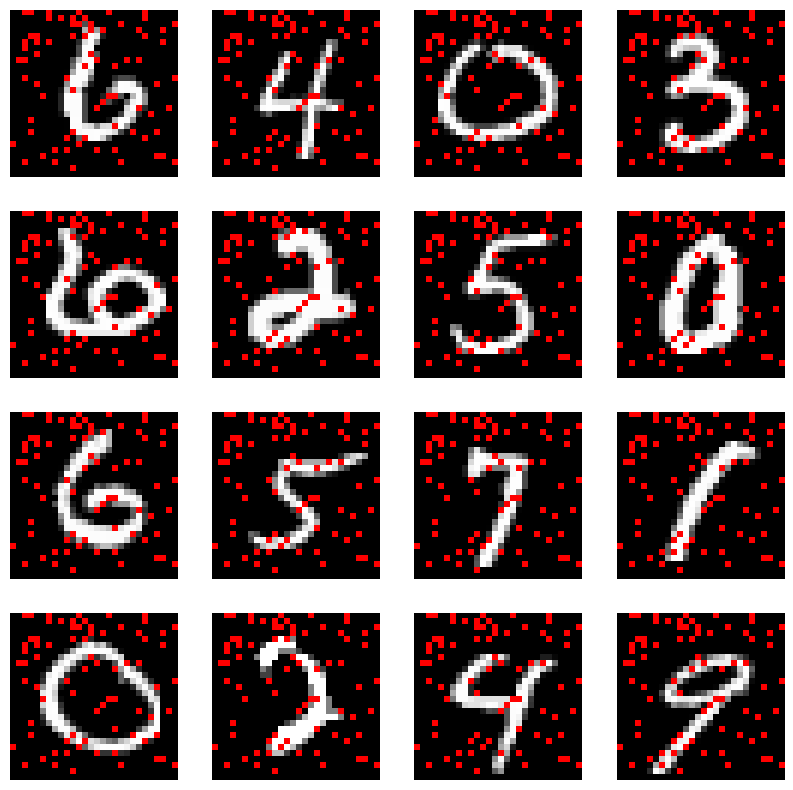

Iteration 0, loss = 2.5726
Iteration 200, loss = 0.8023
Iteration 400, loss = 0.5422
Iteration 600, loss = 0.6360
Checking accuracy on the val set
Got 8945 / 10000 correct (89.45%)
Iteration 0, loss = 0.3285
Iteration 200, loss = 0.5314
Iteration 400, loss = 0.3358
Iteration 600, loss = 0.2963
Checking accuracy on the val set
Got 9123 / 10000 correct (91.23%)
--------------------------------------------------------------------------------------------------------------------------------
3 iteration of pruning done Remaining Features: 85.84183673469389 %
--------------------------------------------------------------------------------------------------------------------------------


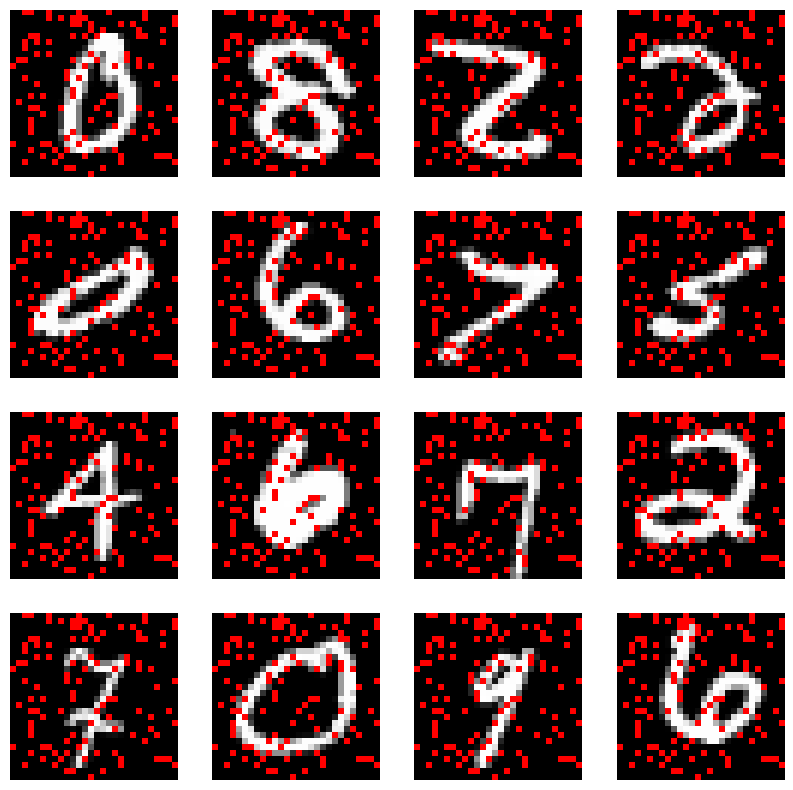

Iteration 0, loss = 2.5026
Iteration 200, loss = 0.6818
Iteration 400, loss = 0.4927
Iteration 600, loss = 0.5951
Checking accuracy on the val set
Got 8920 / 10000 correct (89.20%)
Iteration 0, loss = 0.5086
Iteration 200, loss = 0.3024
Iteration 400, loss = 0.6143
Iteration 600, loss = 0.4713
Checking accuracy on the val set
Got 9118 / 10000 correct (91.18%)
--------------------------------------------------------------------------------------------------------------------------------
4 iteration of pruning done Remaining Features: 81.63265306122449 %
--------------------------------------------------------------------------------------------------------------------------------


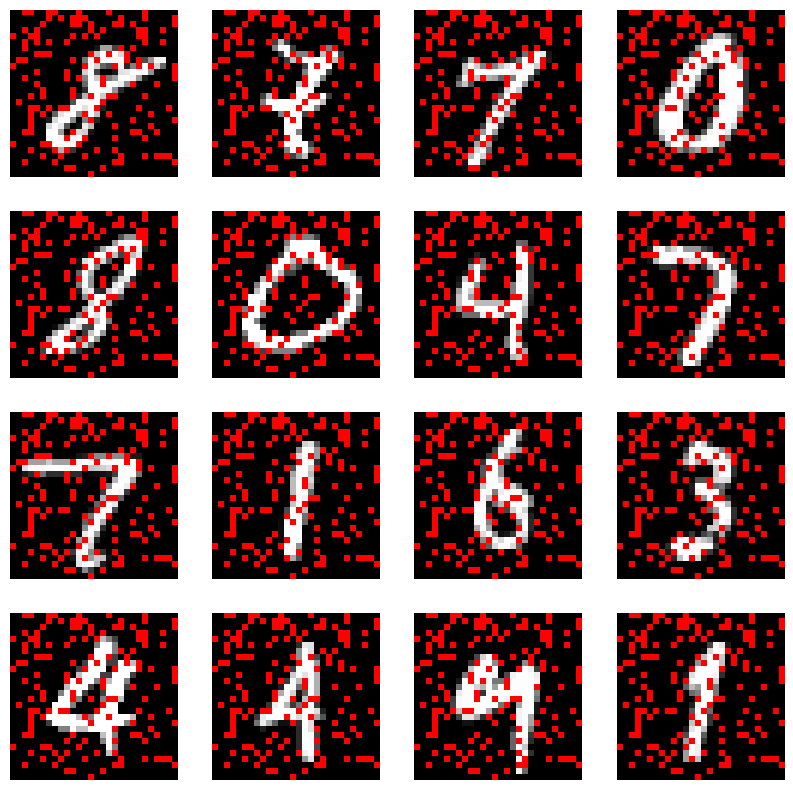

Iteration 0, loss = 2.5753
Iteration 200, loss = 0.8705
Iteration 400, loss = 0.5334
Iteration 600, loss = 0.4588
Checking accuracy on the val set
Got 8953 / 10000 correct (89.53%)
Iteration 0, loss = 0.6105
Iteration 200, loss = 0.5162
Iteration 400, loss = 0.4157
Iteration 600, loss = 0.3672
Checking accuracy on the val set
Got 9143 / 10000 correct (91.43%)
--------------------------------------------------------------------------------------------------------------------------------
5 iteration of pruning done Remaining Features: 77.55102040816327 %
--------------------------------------------------------------------------------------------------------------------------------


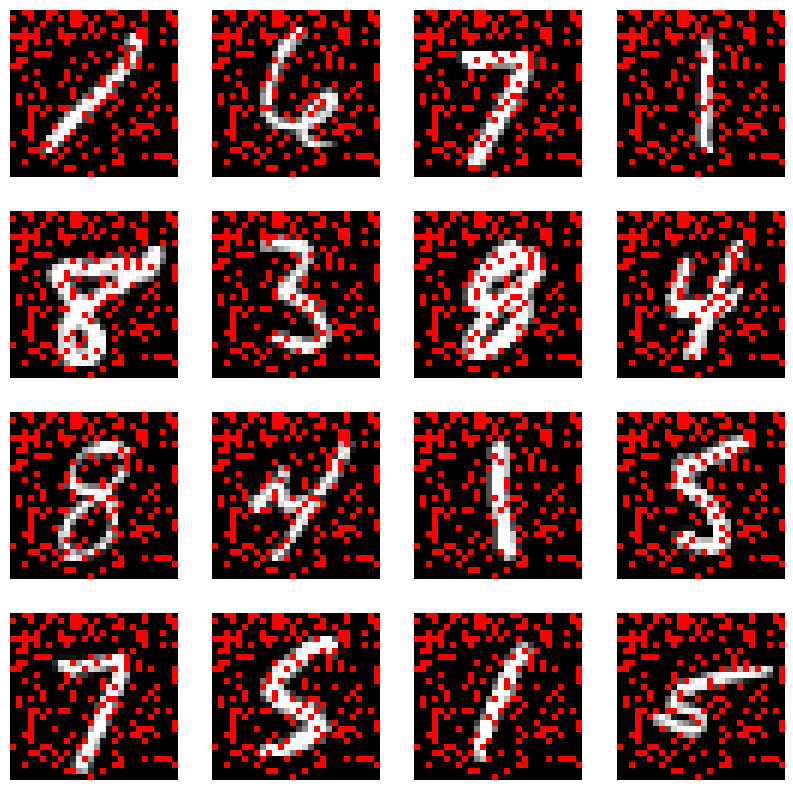

Iteration 0, loss = 2.6351
Iteration 200, loss = 0.9198
Iteration 400, loss = 0.4835
Iteration 600, loss = 0.5911
Checking accuracy on the val set
Got 8931 / 10000 correct (89.31%)
Iteration 0, loss = 0.5111
Iteration 200, loss = 0.4208
Iteration 400, loss = 0.4108
Iteration 600, loss = 0.3968
Checking accuracy on the val set
Got 9130 / 10000 correct (91.30%)
--------------------------------------------------------------------------------------------------------------------------------
6 iteration of pruning done Remaining Features: 73.72448979591837 %
--------------------------------------------------------------------------------------------------------------------------------


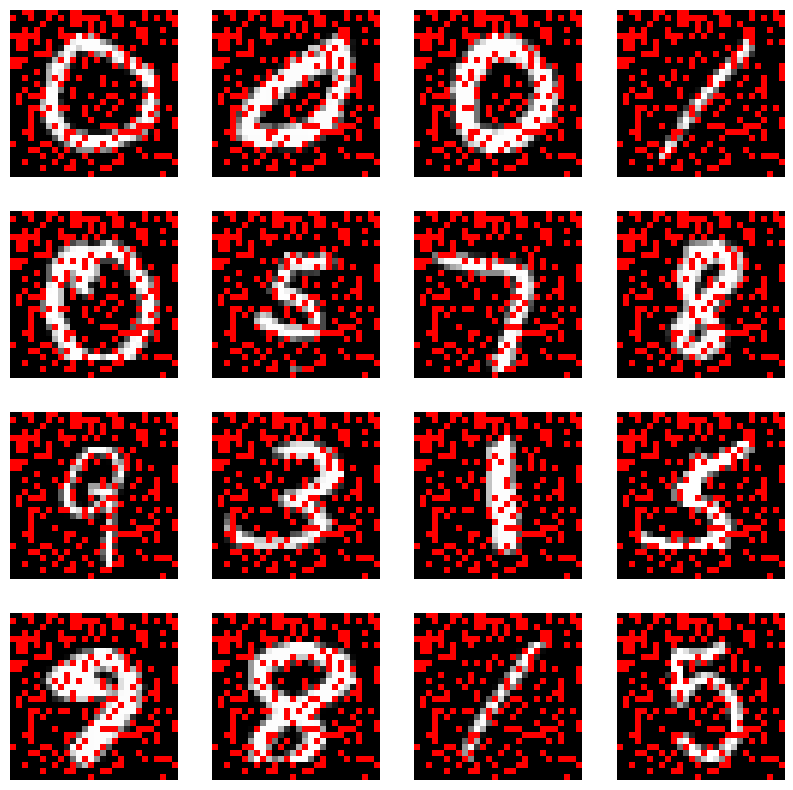

Iteration 0, loss = 2.4832
Iteration 200, loss = 0.7039
Iteration 400, loss = 0.5331
Iteration 600, loss = 0.4736
Checking accuracy on the val set
Got 8935 / 10000 correct (89.35%)
Iteration 0, loss = 0.3951
Iteration 200, loss = 0.5791
Iteration 400, loss = 0.3548
Iteration 600, loss = 0.3514
Checking accuracy on the val set
Got 9132 / 10000 correct (91.32%)
--------------------------------------------------------------------------------------------------------------------------------
7 iteration of pruning done Remaining Features: 70.15306122448979 %
--------------------------------------------------------------------------------------------------------------------------------


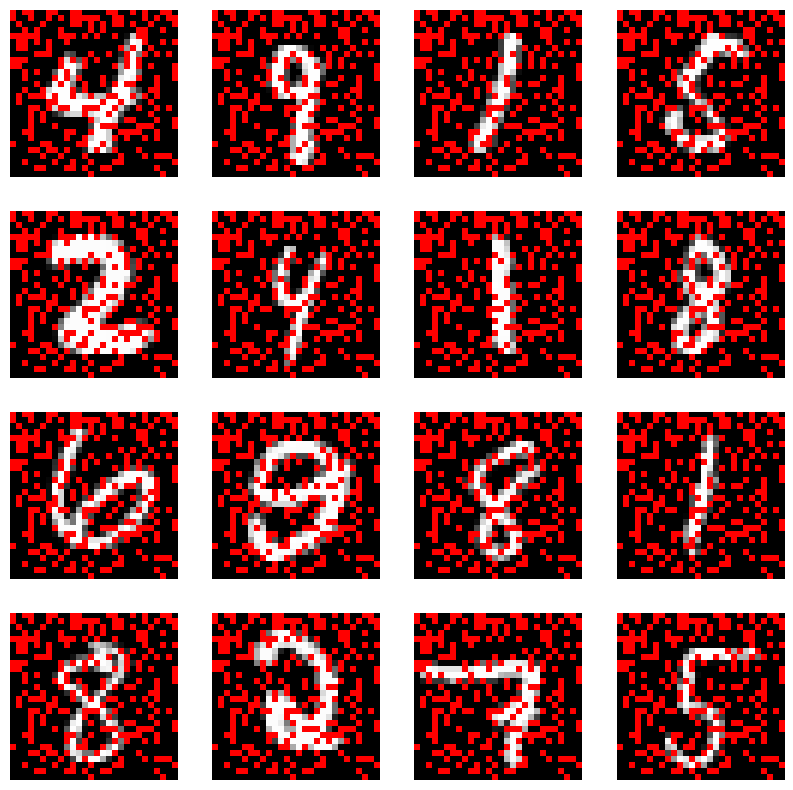

Iteration 0, loss = 2.4663
Iteration 200, loss = 0.6538
Iteration 400, loss = 0.5980
Iteration 600, loss = 0.6567
Checking accuracy on the val set
Got 8936 / 10000 correct (89.36%)
Iteration 0, loss = 0.3502
Iteration 200, loss = 0.3464
Iteration 400, loss = 0.6676
Iteration 600, loss = 0.3210
Checking accuracy on the val set
Got 9126 / 10000 correct (91.26%)
--------------------------------------------------------------------------------------------------------------------------------
8 iteration of pruning done Remaining Features: 66.70918367346938 %
--------------------------------------------------------------------------------------------------------------------------------


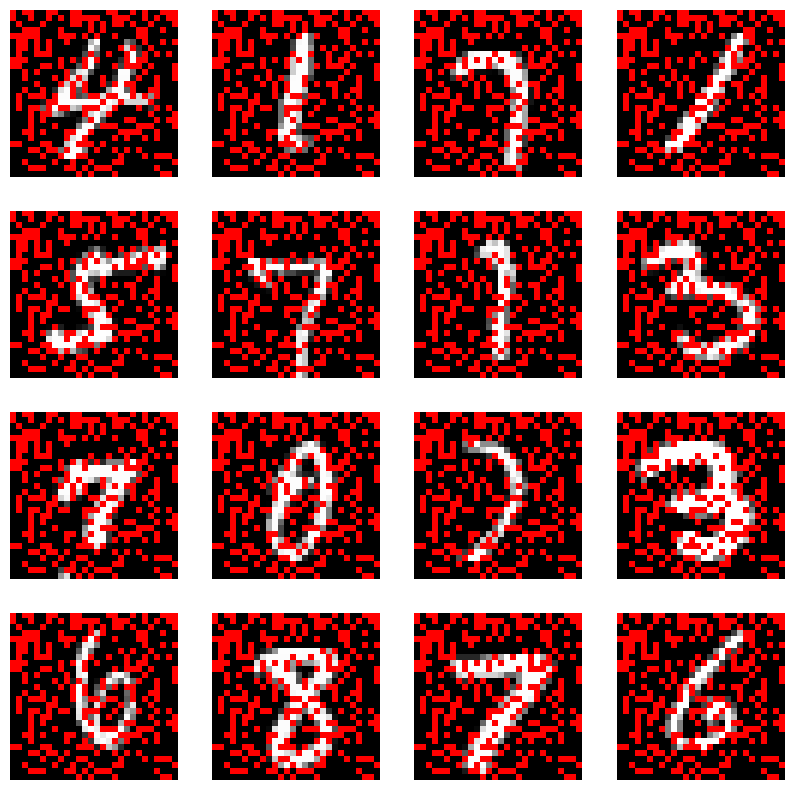

Iteration 0, loss = 2.5389
Iteration 200, loss = 0.8903
Iteration 400, loss = 0.4593
Iteration 600, loss = 0.4875
Checking accuracy on the val set
Got 8925 / 10000 correct (89.25%)
Iteration 0, loss = 0.3688
Iteration 200, loss = 0.3421
Iteration 400, loss = 0.4039
Iteration 600, loss = 0.3365
Checking accuracy on the val set
Got 9099 / 10000 correct (90.99%)
--------------------------------------------------------------------------------------------------------------------------------
9 iteration of pruning done Remaining Features: 63.392857142857146 %
--------------------------------------------------------------------------------------------------------------------------------


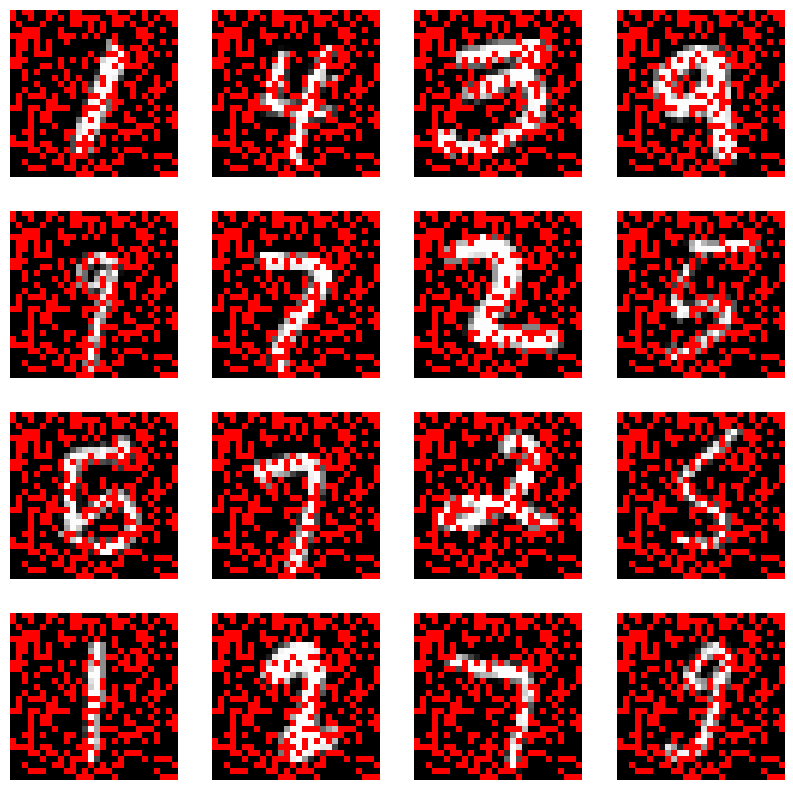

Iteration 0, loss = 2.4898
Iteration 200, loss = 0.9277
Iteration 400, loss = 0.6062
Iteration 600, loss = 0.4675
Checking accuracy on the val set
Got 8916 / 10000 correct (89.16%)
Iteration 0, loss = 0.5041
Iteration 200, loss = 0.5778
Iteration 400, loss = 0.5701
Iteration 600, loss = 0.3430
Checking accuracy on the val set
Got 9116 / 10000 correct (91.16%)
--------------------------------------------------------------------------------------------------------------------------------
10 iteration of pruning done Remaining Features: 60.33163265306122 %
--------------------------------------------------------------------------------------------------------------------------------


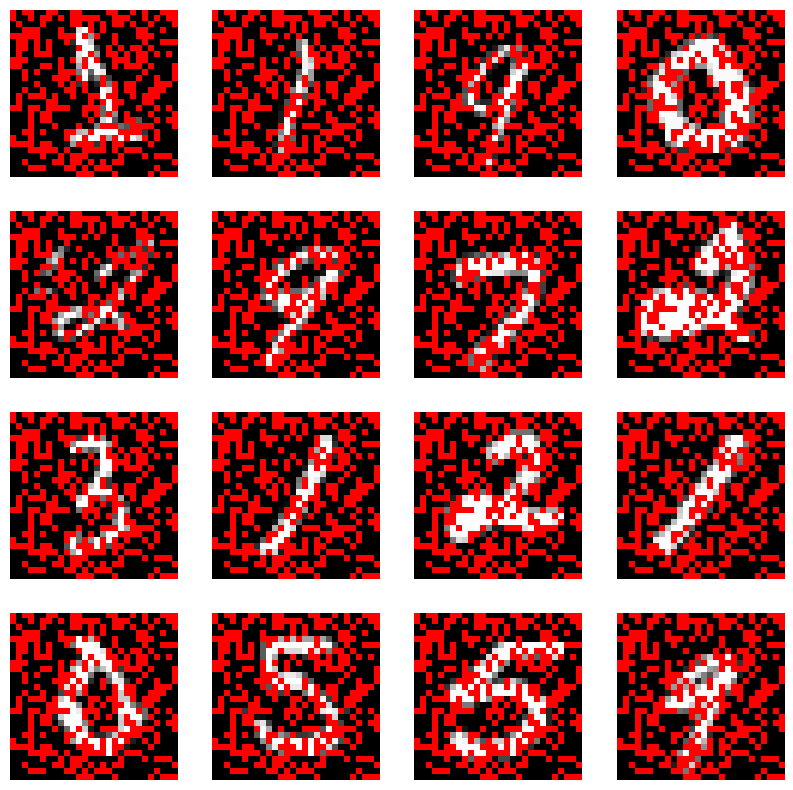

In [25]:
hidden_layer_size = 500
learning_rate = 1e-2

w1 = random_weight((28 * 28, hidden_layer_size))
w2 = random_weight((hidden_layer_size, 10))
mult = random_weight((1, 28 * 28))

initial_w1 = w1.clone().detach().requires_grad_(False)
initial_w2 = w2.clone().detach().requires_grad_(False)
initial_mult = mult.clone().detach().requires_grad_(False)

m1 = torch.ones((28 * 28, hidden_layer_size), dtype=dtype)
m2 = torch.ones((hidden_layer_size, 10), dtype=dtype)
m3 = torch.ones((28 * 28), dtype=dtype)

graph_info = []
tot_pruned = 0
    
for k in range(10):
    # train for 2 epochs
    acc = train(two_layer_fc, [w1, w2, mult, m1, m2, m3], learning_rate, print_every=200)
    acc = train(two_layer_fc, [w1, w2, mult, m1, m2, m3], learning_rate, print_every=200)
    
    # prune feature weights

    temp = []
    for i in range(28 * 28):
        if (m3[i] == 1):
            temp.append(abs(mult[0][i].item()))

    temp = list(sorted(temp))
    thres = temp[int(0.05 * len(temp))]

    for i in range(28 * 28):
        if abs(mult[0][i].item()) < thres and m3[i] == 1:
            m3[i] = 0
            tot_pruned += 1
            
    mult = initial_mult.clone().detach().requires_grad_(True)
    
    print('-' * 128)
    print(k+1, "iteration of pruning done", "Remaining Features:", 100 - tot_pruned / (28 * 28) * 100, "%")
    print('-' * 128)
    
    images, labels = next(iter(loader_train))

    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].permute(1, 2, 0))
        
        to_pil = T.ToPILImage()
        pil_image = to_pil(images[i])

        
        rgb_image = pil_image.convert("RGB")
        
        for i in range(rgb_image.size[0]):
            for j in range(rgb_image.size[1]):
                if m3[i * 28 + j].item() == 0:
                    rgb_image.putpixel((i, j), (255, 0, 0))
        
        ax.imshow(rgb_image)
        
        ax.axis('off')

    plt.show()
    
    # Reset the weights
    w1 = initial_w1.clone().detach().requires_grad_(True)
    w2 = initial_w2.clone().detach().requires_grad_(True)
    
    graph_info.append((100 - tot_pruned / (28 * 28) * 100, acc))



In [26]:
import random
print("Accuracy with feature subset, original random weights")
print(train(two_layer_fc, [w1, w2, torch.ones((28 * 28), dtype=dtype, requires_grad=True), m1, m2, m3], learning_rate, print_every=100, verbose=True))


print("Accuracy with feature subset, new random weights")
print(train(two_layer_fc, [random_weight((28 * 28, hidden_layer_size)), random_weight((hidden_layer_size, 10)), torch.ones((28 * 28), dtype=dtype, requires_grad=True), m1, m2, m3], learning_rate, print_every=1, verbose = False))


temp = torch.ones((28 * 28), dtype=dtype)
random_indices = random.sample(range(temp.shape[0]), 14 * 28)
for i in random_indices:
    temp[i] = 0

print(temp)

print("Accuracy with random feature subset, random weights")
print(train(two_layer_fc, [random_weight((28 * 28, hidden_layer_size)), random_weight((hidden_layer_size, 10)),
                           torch.ones((28 * 28), dtype=dtype, requires_grad=True), m1, m2, temp], 
            learning_rate, print_every=1, verbose = False))


Accuracy with feature subset, original random weights
Iteration 0, loss = 2.3574
Iteration 100, loss = 1.6927
Iteration 200, loss = 1.2566
Iteration 300, loss = 0.9323
Iteration 400, loss = 0.8307
Iteration 500, loss = 0.7636
Iteration 600, loss = 0.5397
Iteration 700, loss = 0.6730
Checking accuracy on the val set
Got 8798 / 10000 correct (87.98%)
0.8798
Accuracy with feature subset, new random weights
Checking accuracy on the val set
Got 8758 / 10000 correct (87.58%)
0.8758
tensor([1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
        1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.,
        0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1.,
        0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0.,
        1., 0., 0., 0., 0., 1., 1., 0.,

In [ ]:
import matplotlib.pyplot as plt

# Extract x and y values from graph_info
x_values = [item[0] for item in graph_info]
y_values = [item[1] for item in graph_info]

print(x_values)
print(y_values)

# Plot the data
plt.plot(x_values, y_values)

# Reverse order of x-axis
plt.gca().invert_xaxis()

# find x axis labels more fine grained
plt.xticks(np.arange(60, 100, 5))

plt.xlabel('Percentage of remaining weights')
plt.ylabel('Accuracy')

# Show the plot
plt.show()
# Set x-axis scale to logarithmic with a multiplier coefficient of 0.4

